In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# 1. Data analysis <a id="section1"></a>

First of all, let's take a look on the data structure:

In [55]:
test = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
train.Province_State.fillna("None", inplace=True)
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train.loc[train['Province_State']!='None']['Country_Region'].unique())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,None,Afghanistan,2020-01-22,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,29422.000000,29422.000000,29422.000000
mean,17831.500000,1878.005404,112.546836
std,10300.664373,11954.991497,1078.620259
min,1.000000,-1.000000,-1.000000
25%,8916.250000,0.000000,0.000000
50%,17831.500000,4.000000,0.000000
75%,26746.750000,207.000000,2.000000
max,35662.000000,271590.000000,25969.000000


Number of Country_Region:  184
Dates go from day 2020-04-24 to day 2020-01-22 , a total of 94 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [56]:
train.shape

(29422, 6)

Text(0.5, 0, 'Date')

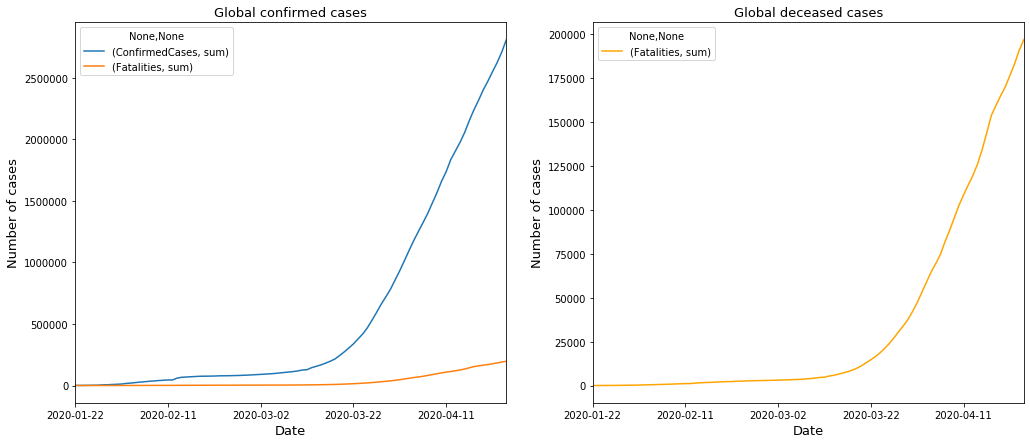

In [57]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

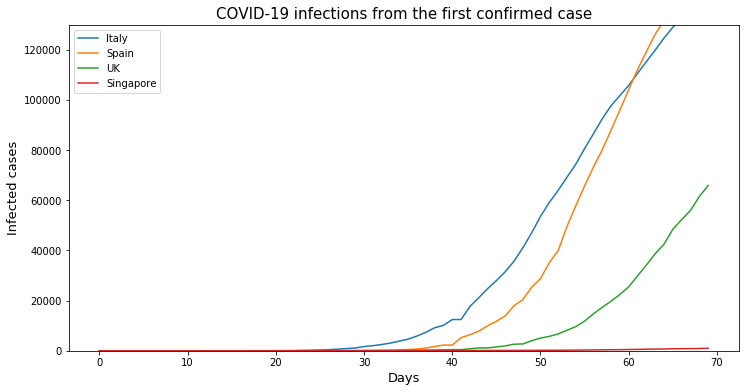

In [58]:
#confirmed_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:70] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:70] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:70] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:70] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.legend(["Italy", "Spain", "UK", "Singapore"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 130000)
plt.show()

# 2. Data enrichment <a id="section3"></a>



## 2.1. Join data, filter dates and clean missings <a id="section31"></a>


In [59]:
train['ConfirmedCases']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
29417    25.0
29418    28.0
29419    28.0
29420    28.0
29421    29.0
Name: ConfirmedCases, Length: 29422, dtype: float64

In [60]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
                 '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-04-01', 'ConfirmedCases'] = 0
all_data.loc[all_data['Date'] >= '2020-04-01', 'Fatalities'] = 0
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-04-01'])

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,5,2020
13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,5,2020
13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,5,2020
13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,5,2020


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year


In [13]:
for i in all_data['ConfirmedCases']:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
4.0
4.0
5.0
7.0
7.0
7.0
11.0
16.0
21.0
22.0
22.0
22.0
24.0
24.0
40.0
40.0
74.0
84.0
94.0
110.0
110.0
120.0
170.0
174.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
10.0
12.0
23.0
33.0
38.0
42.0
51.0
55.0
59.0
64.0
70.0
76.0
89.0
104.0
123.0
146.0
174.0
186.0
197.0
212.0
223.0
243.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
3.0
5.0
12.0
12.0
17.0
17.0
19.0
20.0
20.0
20.0
24.0
26.0
37.0
48.0
54.0
60.0
74.0
87.0
90.0
139.0
201.0
230.0
264.0
302.0
367.0
409.0
454.0
511.0

In [14]:
to_grab = all_data.copy()

**Observations**: 
* "ConfirmedCases" and "Fatalities" are now only informed for dates previous to 2020-03-12
* The dataset includes all countries and dates, which is required for the lag/trend step
* Missing values for "ConfirmedCases" and "Fatalities" have been replaced by 0, which may be dangerous if we do not remember it at the end of the process. However, since we will train only on dates previous to 2020-03-12, this won't impact our prediction algorithm
* A new column "Day" has been created, as a day counter starting from the first date

Double-check that there are no remaining missing values:

In [15]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


## 2.2. Compute lags and trends <a id="section32"></a>

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


In [16]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['Country_Region', 'Province_State'])[column].shift(0, fill_value=0) - 
                                df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0))/df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0.001)
    return df


ts = time.time()
all_data = calculate_lag(all_data.reset_index(), range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  3.2201483249664307


As you see, the process is really fast. An example of some of the lag/trend columns for Spain:

In [17]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
17800,25349.0,None,Spain,2020-03-02,120.0,0.0,-1.0,40,84.0,45.0,32.0,0.0,0.0,0.0
17801,25350.0,None,Spain,2020-03-03,165.0,1.0,-1.0,41,120.0,84.0,45.0,0.0,0.0,0.0
17802,25351.0,None,Spain,2020-03-04,222.0,2.0,-1.0,42,165.0,120.0,84.0,1.0,0.0,0.0
17803,25352.0,None,Spain,2020-03-05,259.0,3.0,-1.0,43,222.0,165.0,120.0,2.0,1.0,0.0
17804,25353.0,None,Spain,2020-03-06,400.0,5.0,-1.0,44,259.0,222.0,165.0,3.0,2.0,1.0
17805,25354.0,None,Spain,2020-03-07,500.0,10.0,-1.0,45,400.0,259.0,222.0,5.0,3.0,2.0
17806,25355.0,None,Spain,2020-03-08,673.0,17.0,-1.0,46,500.0,400.0,259.0,10.0,5.0,3.0
17807,25356.0,None,Spain,2020-03-09,1073.0,28.0,-1.0,47,673.0,500.0,400.0,17.0,10.0,5.0
17808,25357.0,None,Spain,2020-03-10,1695.0,35.0,-1.0,48,1073.0,673.0,500.0,28.0,17.0,10.0
17809,25358.0,None,Spain,2020-03-11,2277.0,54.0,-1.0,49,1695.0,1073.0,673.0,35.0,28.0,17.0


In [18]:
all_data

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38494,13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38495,13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38496,13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38497,13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.3. Add per country population details <a id="section33"></a>

Uing [Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020) we will create more features for linear regression to use.

In [19]:
# Load countries data file
world_population = pd.read_csv("../input/population-by-country-2020/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1438116346,153,9388211,38,61
1,India,1377011281,464,2973190,28,35
2,US,330578810,36,9147420,38,83
3,Indonesia,272884327,151,1811570,30,56
4,Pakistan,219922471,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4991,50,100,19,10
231,Falkland Islands,3457,0,12170,19,66
232,Niue,1624,6,260,19,46
233,Tokelau,1353,136,10,19,0


Joined dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,Afghanistan,38728504.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38494,13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0
38495,13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0
38496,13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0
38497,13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,Zimbabwe,14814609.0,38.0,386850.0,19.0,38.0


Encoded dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,83,0,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
1,1,2.0,83,0,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
2,2,3.0,83,0,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
3,3,4.0,83,0,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
4,4,5.0,83,0,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,0.0,38728504.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38494,13454,-1.0,83,183,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0
38495,13455,-1.0,83,183,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0
38496,13456,-1.0,83,183,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0
38497,13457,-1.0,83,183,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,0.0,14814609.0,38.0,386850.0,19.0,38.0


# 4. Predictions for the early stages of the transmission <a id="section4"></a>
Models to apply:
1. Linear Regression for one country
2. Linear Regression for one country with Lags

## 4.1. Baseline: Linear Regression for one country 

This is an elementary model with no proper feature generation introduced like lags and trends. This model is to calculate the feasibility of linear regression and evaluate how well it is able to encapsulate the initial outbreak.

Linear Regression workflow:

1.     Features: the growth rate and the population for reach country.    

2.    Training dates: 03-10-2020 to 03-25-2020 and 03-10-2020 to 03-30-2020

3.    Log transformation: Fatalities and transmissibility (Confirmed cases)

4.    Infinites: replaced infinities with 0. Additionally, the inverse was returned because of asymptomatic behavior. 

5.    Train/test split: data was split in a train set, valid set, and testing set.

6.    Prediction: Linear regression where each country was used in training and the data was joined.  





Text(0, 0.5, 'Log ConfirmedCases')

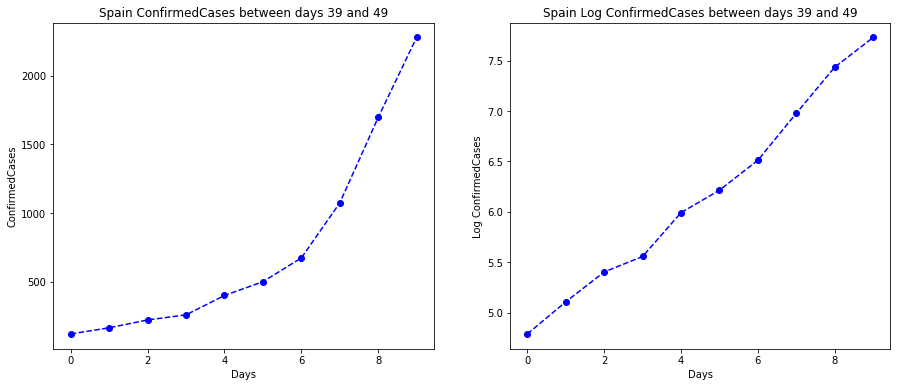

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

* Initial stages of infection are represented by an effectively exponential curve. This represents the condition most countries are experiencing.
* Reasoning behind the selection of data values for 10 days:
    1. To witness the initial and immediate influence of the virus.
    2. Reduce impact of extraneous variables.


In [21]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    # Train set
    x_train = df[df.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = df[df.ForecastId == -1]['ConfirmedCases']
    y_train_2 = df[df.ForecastId == -1]['Fatalities']
    
    print(x_train.shape, y_train_1.shape)

    # Test set
    x_test = df[df.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

Let's try to see results when training with a single country:

* **Spain**

In [22]:
# Select train (real) data from March 1 to last day updated
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', 
                 '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14']

In [23]:
all_data.loc[all_data['Country_Region']==country_dict['Spain']][50:70]

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
17810,20918,25359.0,83,156,2020-03-12,2277.0,55.0,-1.0,50,12,...,0.571429,0.964286,2.235294,4.500000,10.000000,46750879.0,94.0,498800.0,45.0,80.0
17811,20919,25360.0,83,156,2020-03-13,5232.0,133.0,-1.0,51,13,...,1.462963,2.800000,3.750000,6.823529,12.300000,46750879.0,94.0,498800.0,45.0,80.0
17812,20920,25361.0,83,156,2020-03-14,6391.0,195.0,-1.0,52,14,...,2.545455,2.611111,4.571429,5.964286,10.470588,46750879.0,94.0,498800.0,45.0,80.0
17813,20921,25362.0,83,156,2020-03-15,7798.0,289.0,-1.0,53,15,...,1.172932,4.254545,4.351852,7.257143,9.321429,46750879.0,94.0,498800.0,45.0,80.0
17814,20922,25363.0,83,156,2020-03-16,9942.0,342.0,-1.0,54,16,...,0.753846,1.571429,5.218182,5.333333,8.771429,46750879.0,94.0,498800.0,45.0,80.0
17815,20923,25364.0,83,156,2020-03-17,11748.0,533.0,-1.0,55,17,...,0.844291,1.733333,3.007519,8.690909,8.870370,46750879.0,94.0,498800.0,45.0,80.0
17816,20924,25365.0,83,156,2020-03-18,13910.0,623.0,-1.0,56,18,...,0.821637,1.155709,2.194872,3.684211,10.327273,46750879.0,94.0,498800.0,45.0,80.0
17817,20925,25366.0,83,156,2020-03-19,17963.0,830.0,-1.0,57,19,...,0.557223,1.426901,1.871972,3.256410,5.240602,46750879.0,94.0,498800.0,45.0,80.0
17818,20926,25367.0,83,156,2020-03-20,20410.0,1043.0,-1.0,58,20,...,0.674157,0.956848,2.049708,2.608997,4.348718,46750879.0,94.0,498800.0,45.0,80.0
17819,20927,25368.0,83,156,2020-03-21,25374.0,1375.0,-1.0,59,21,...,0.656627,1.207063,1.579737,3.020468,3.757785,46750879.0,94.0,498800.0,45.0,80.0


In [24]:
data

,Id,ForecastId,Country_Region,Province_State,ConfirmedCases,Fatalities,Day_num
0,1.0,-1.0,0,83,0.0,0.0,0
1,2.0,-1.0,0,83,0.0,0.0,1
2,3.0,-1.0,0,83,0.0,0.0,2
3,4.0,-1.0,0,83,0.0,0.0,3
4,5.0,-1.0,0,83,0.0,0.0,4
...,...,...,...,...,...,...,...
38494,-1.0,13455.0,183,83,0.0,0.0,108
38495,-1.0,13456.0,183,83,0.0,0.0,109
38496,-1.0,13457.0,183,83,0.0,0.0,110
38497,-1.0,13458.0,183,83,0.0,0.0,111


In [25]:
data

,Id,ForecastId,Country_Region,Province_State,ConfirmedCases,Fatalities,Day_num
0,1.0,-1.0,0,83,0.0,0.0,0
1,2.0,-1.0,0,83,0.0,0.0,1
2,3.0,-1.0,0,83,0.0,0.0,2
3,4.0,-1.0,0,83,0.0,0.0,3
4,5.0,-1.0,0,83,0.0,0.0,4
...,...,...,...,...,...,...,...
38494,-1.0,13455.0,183,83,0.0,0.0,108
38495,-1.0,13456.0,183,83,0.0,0.0,109
38496,-1.0,13457.0,183,83,0.0,0.0,110
38497,-1.0,13458.0,183,83,0.0,0.0,111


In [26]:
data.shape

(38499, 7)

In [27]:
to_grab.shape

(38499, 11)

In [28]:
def plot_linreg_basic_country_get_data(data, country_name, dates_list, day_start, shift, train_lim, test_lim):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    print(data_country)
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, train_lim, test_lim)
    return X_train, Y_train_1, Y_train_2, X_test

In [29]:
def get_results(conf, fat):
    conf_results = conf.values.tolist()
    fat_results = fat.values.tolist()
    
    months = range(1, conf.shape[0]+1)
    plt.bar(months, conf_results)
    plt.xticks(months)
    plt.ylabel('Confirmed Covid-19 Cases')
    plt.xlabel('March day num')
    plt.show()
    
    months = range(1, fat.shape[0]+1)
    plt.bar(months, fat_results)
    plt.xticks(months)
    plt.ylabel('Fatalities Covid-19 Cases')
    plt.xlabel('March day num')
    plt.show()


    x = months
    y = conf_results
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    conf_data = dict()
    conf_data['slope'] = slope
    conf_data['intercept'] = intercept
    conf_data['r_value'] = r_value
    conf_data['p_value'] = p_value
    conf_data['std_err'] = std_err
    
    y = conf_results
    fat_slope, fat_intercept, fat_r_value, fat_p_value, fat_std_err = stats.linregress(x,fat_results)
    
    fat_data = dict()
    fat_data['slope'] = fat_slope
    fat_data['intercept'] = fat_intercept
    fat_data['r_value'] = fat_r_value
    fat_data['p_value'] = fat_p_value
    fat_data['std_err'] = fat_std_err
    
    return [conf_data, fat_data]
    

            Id  ForecastId  Country_Region  Province_State  ConfirmedCases  \
17809  25358.0        -1.0             156              83        7.731053   
17810  25359.0        -1.0             156              83        7.731053   
17811  25360.0        -1.0             156              83        8.562740   
17812  25361.0        -1.0             156              83        8.762802   
17813  25362.0        -1.0             156              83        8.961751   
...        ...         ...             ...             ...             ...   
34624     -1.0      9585.0             156              83        0.000000   
34625     -1.0      9586.0             156              83        0.000000   
34626     -1.0      9587.0             156              83        0.000000   
34627     -1.0      9588.0             156              83        0.000000   
34628     -1.0      9589.0             156              83        0.000000   

       Fatalities  Day_num  
17809    4.007333       49  
17810

ValueError: x and y must have same first dimension, but have shapes (36,) and (43,)

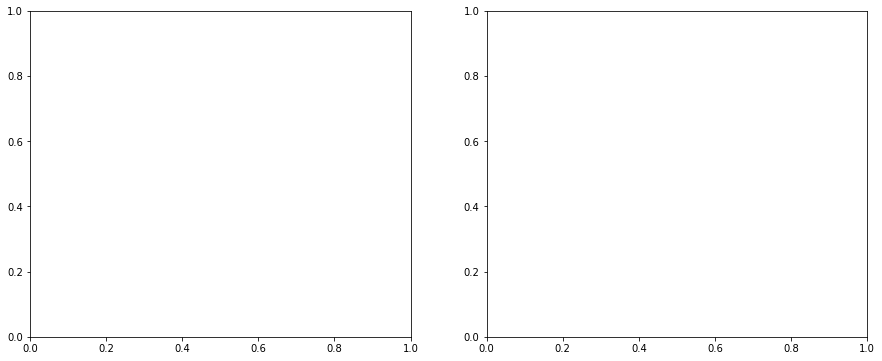

In [30]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift, train_lim, test_lim):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    print(data_country)
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, train_lim, test_lim)
    model, pred = lin_reg(X_train, Y_train_1, X_test)
    print(pred.shape)
    # Create a df with both real cases and predictions (predictions starting on March 12th)
    X_train_check = X_train.copy()
    print("X_train_check", X_train_check.shape)
    X_train_check['Target'] = Y_train_1
    print("Y_train_1",Y_train_1.shape)
    
    X_test_check = X_test.copy()
    X_test_check['Target'] = pred
    print("X_test_check",X_test_check.shape)
    print("pred", pred.shape)
    
    X_final_check = pd.concat([X_train_check, X_test_check])
    print("X_final_check", X_final_check.shape)
    print(X_final_check)
    
    # Select predictions from March 1st to March 25th
    predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)+1))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    ax1.plot(dates_list_num, np.expm1(pred))
    #ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (from March " + str(1+shift) + " to March 25th)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (from March " + str(1+shift) + " to March 30th)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
    
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 69, 112
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

17820    28768.000000
17821    35136.000000
17822    39885.000000
17823    49515.000000
17824    57786.000000
17825    65719.000000
17826    73235.000000
17827    80110.000000
17828    87956.000000
17829    95923.000000
17830        0.000000
34586     3440.062595
34587     2205.465414
34588     1413.821582
34589      906.206655
34590      580.715692
34591      372.005582
34592      238.177258
34593      152.364355
34594       97.339724
34595       62.057034
34596       39.433198
34597       24.926425
34598       15.624446
34599        9.659866
Name: Target, dtype: float64


ValueError: x and y must have same first dimension, but have shapes (24,) and (25,)

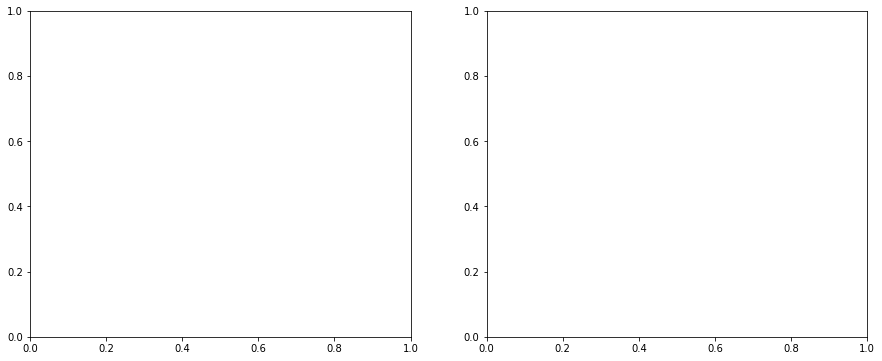

In [26]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [31]:
to_grab = to_grab[features]

In [45]:
data.shape

(38499, 7)

In [46]:
to_grab.shape

(38499, 7)

In [48]:
for i in data['ConfirmedCases']:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
0.6931471805599453
1.6094379124341003
1.6094379124341003
1.791759469228055
2.0794415416798357
2.0794415416798357
2.0794415416798357
2.4849066497880004
2.833213344056216
3.091042453358316
3.1354942159291497
3.1354942159291497
3.1354942159291497
3.2188758248682006
3.2188758248682006
3.713572066704308
3.713572066704308
4.31748811353631
4.442651256490317
4.553876891600541
4.709530201312334
4.709530201312334
4.795790545596741
5.14166355650266
5.1647859739235145
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

* **Italy**

In [50]:
data

,Id,ForecastId,Country_Region,Province_State,ConfirmedCases,Fatalities,Day_num
0,1.0,-1.0,0,83,0.0,0.0,0
1,2.0,-1.0,0,83,0.0,0.0,1
2,3.0,-1.0,0,83,0.0,0.0,2
3,4.0,-1.0,0,83,0.0,0.0,3
4,5.0,-1.0,0,83,0.0,0.0,4
...,...,...,...,...,...,...,...
38494,-1.0,13455.0,183,83,0.0,0.0,108
38495,-1.0,13456.0,183,83,0.0,0.0,109
38496,-1.0,13457.0,183,83,0.0,0.0,110
38497,-1.0,13458.0,183,83,0.0,0.0,111


In [87]:
# Doing Stats analysis

In [ ]:
temp = to_grab.copy()

In [44]:
to_grab = temp.copy()

In [45]:
country_name = "Italy"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]

In [46]:
to_grab = to_grab[to_grab['Country_Region']==country_name]
to_grab = to_grab.loc[to_grab['Day_num']>=day_start]

In [47]:
to_grab.loc[to_grab['Day_num']<=train_lim , 'ForecastId'] = -1
to_grab = to_grab[to_grab['Day_num']<=test_lim]


In [48]:
x_train = to_grab[to_grab.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
y_train_1 = to_grab[to_grab.ForecastId == -1]['ConfirmedCases']
y_train_2 = to_grab[to_grab.ForecastId == -1]['Fatalities']


In [49]:
# Test set
x_test = to_grab[to_grab.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

# Clean Id columns and keep ForecastId as index
x_train.drop('Id', inplace=True, errors='ignore', axis=1)
x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
x_test.drop('Id', inplace=True, errors='ignore', axis=1)
x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)

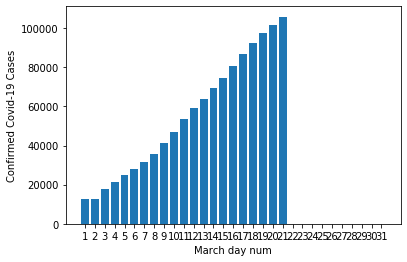

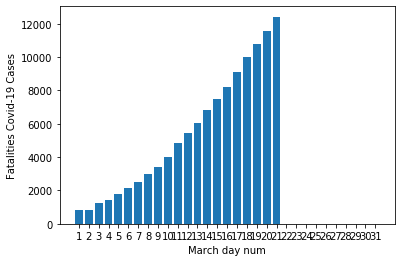

In [50]:
conf_data, fat_data = get_results(y_train_1, y_train_2)

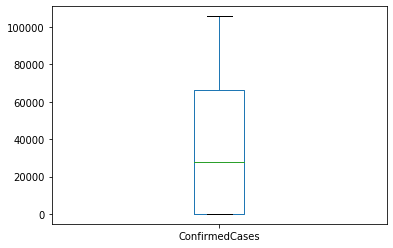

In [51]:
y_train_1.plot.box()

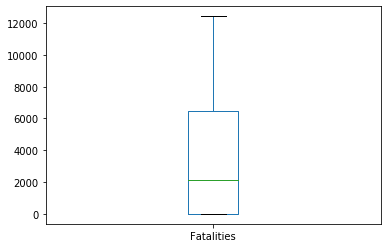

In [52]:
y_train_2.plot.box()

In [53]:
conf_data

{'slope': -783.8887096774193,
 'intercept': 49855.993548387094,
 'r_value': -0.19554619060659334,
 'p_value': 0.29177589804459236,
 'std_err': 730.0284522612809}

In [54]:
fat_data

{'slope': -43.94032258064516,
 'intercept': 4384.238709677419,
 'r_value': -0.09933603329582749,
 'p_value': 0.5949550623519428,
 'std_err': 81.73424473964253}

In [42]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

Empty DataFrame
Columns: [Id, ForecastId, Country_Region, Province_State, ConfirmedCases, Fatalities, Day_num]
Index: []
(0, 5) (0,)


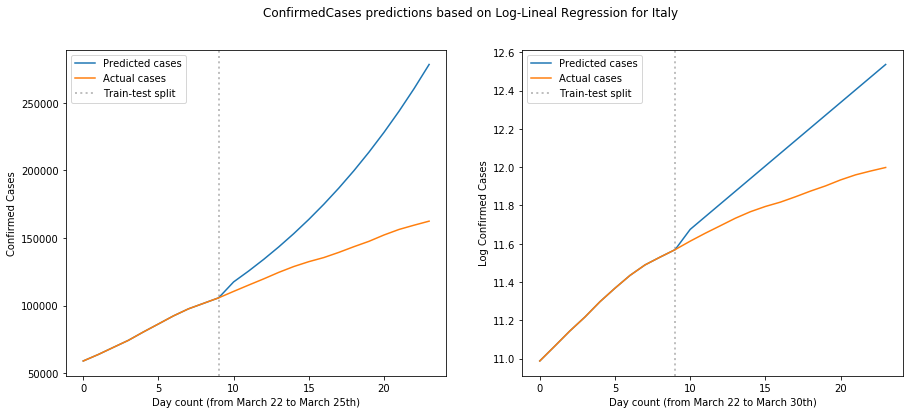

In [26]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **Germany**

In [33]:
temp = to_grab.copy()

In [34]:
country_name = "Germany"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]

In [35]:
to_grab = to_grab[to_grab['Country_Region']==country_name]
to_grab = to_grab.loc[to_grab['Day_num']>=day_start]

In [36]:
to_grab.loc[to_grab['Day_num']<=train_lim , 'ForecastId'] = -1
to_grab = to_grab[to_grab['Day_num']<=test_lim]


In [37]:
x_train = to_grab[to_grab.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
y_train_1 = to_grab[to_grab.ForecastId == -1]['ConfirmedCases']
y_train_2 = to_grab[to_grab.ForecastId == -1]['Fatalities']


In [38]:
# Test set
x_test = to_grab[to_grab.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

# Clean Id columns and keep ForecastId as index
x_train.drop('Id', inplace=True, errors='ignore', axis=1)
x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
x_test.drop('Id', inplace=True, errors='ignore', axis=1)
x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)

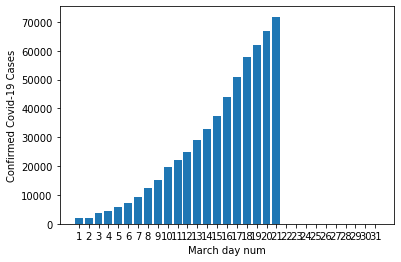

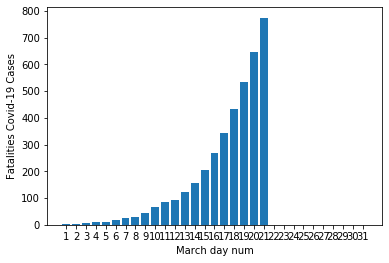

In [39]:
conf_data, fat_data = get_results(y_train_1, y_train_2)

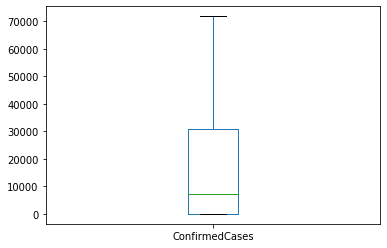

In [40]:
y_train_1.plot.box()

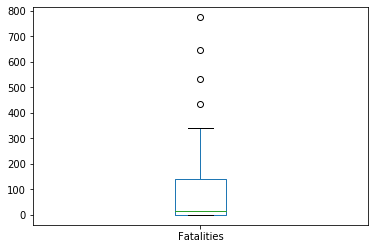

In [41]:
y_train_2.plot.box()

In [42]:
conf_data

{'slope': -51.25927419354839,
 'intercept': 19588.148387096775,
 'r_value': -0.020278502894711312,
 'p_value': 0.9137759108828645,
 'std_err': 469.297511470728}

In [43]:
fat_data

{'slope': 2.3588709677419364,
 'intercept': 87.16129032258064,
 'r_value': 0.1030562936586519,
 'p_value': 0.5811634878237709,
 'std_err': 4.227777263664517}

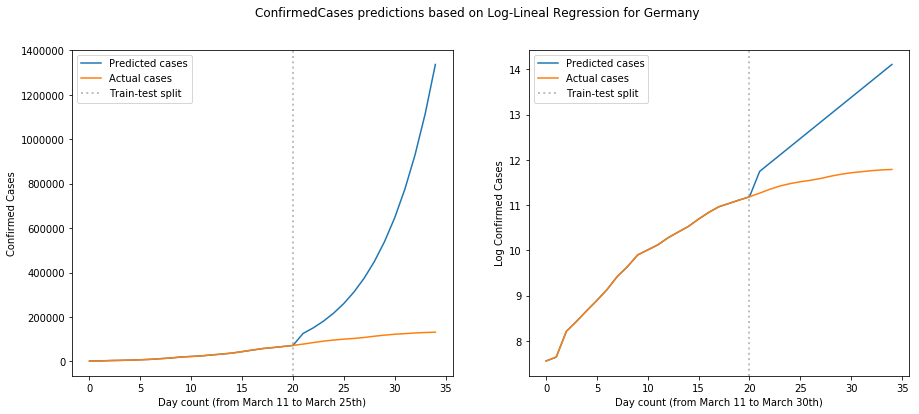

In [27]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

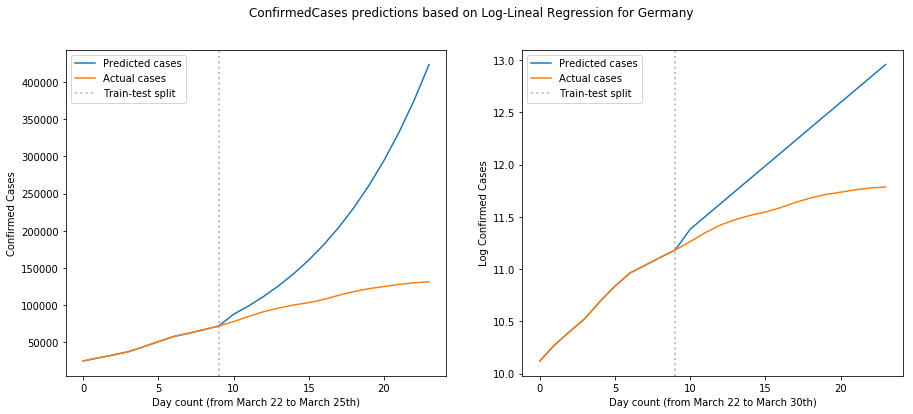

In [28]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **Albania**

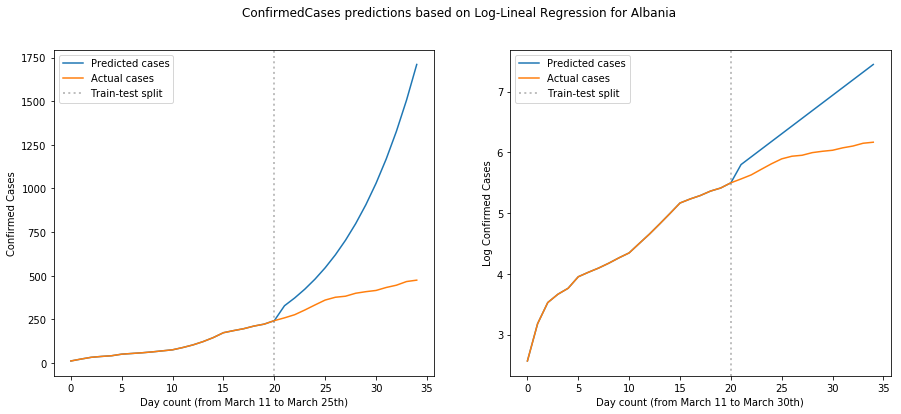

In [29]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

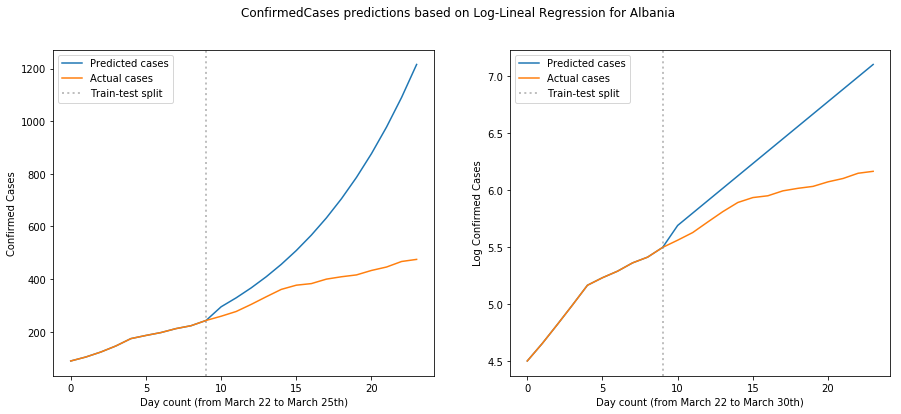

In [30]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **Andorra**

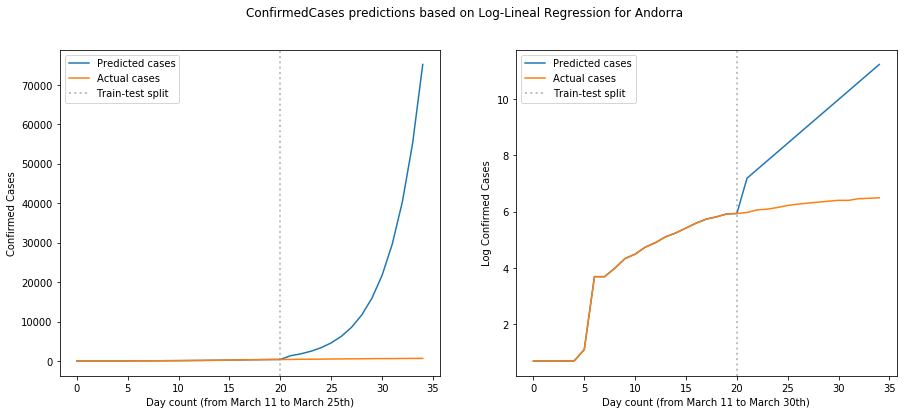

In [31]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 10
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift, train_lim, test_lim)

## 4.4. Final Model: Linear regression with lags

The linear regression turned out to be a good model for the purposes of gaining insight on the initial stages of the spread. It should be noted, our results only represent the initial outbreak – no claims about the reduction in confirmed cases or fatalities can be expressed.


##### Approach to solving unknown lags:

1. Begin with train dataset.
2. Predict the following day using Linear Regression
3. Confirmed cases and Fatalities will be the new prediction.
4. Compute lags again
5. Repeat steps 2 to 4 for the days that remain

In [22]:
# New split function, for one forecast day
def split_data_one_day(df, d, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    #Train
    x_train = df[df.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = df[df.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + "))")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Log-Lineal Regression for "+country_name))

* **Spain**

In [ ]:
# Function to compute the Linear Regression predictions with lags, for a certain Country/Region
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country_Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data



# Run the model for Spain
country_name = 'Spain'
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Italy**

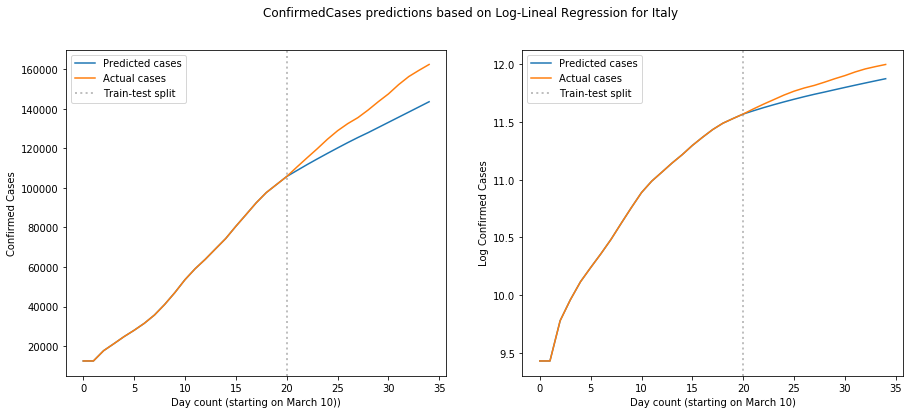

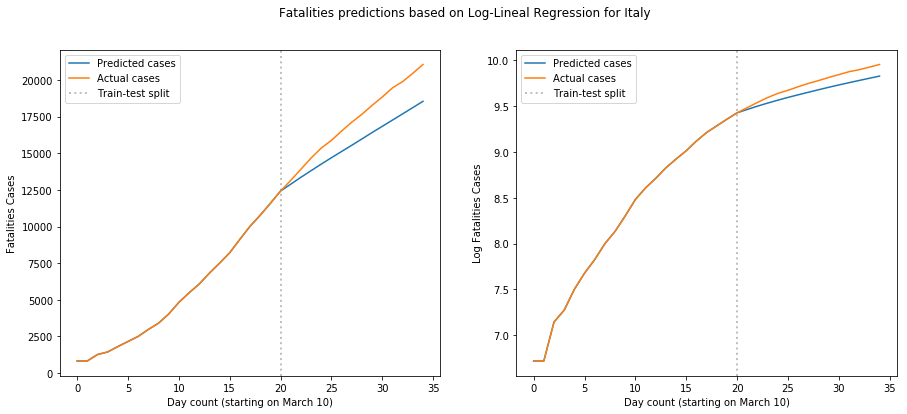

In [37]:
ts = time.time()

# Inputs
country_name = "Italy"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Germany**

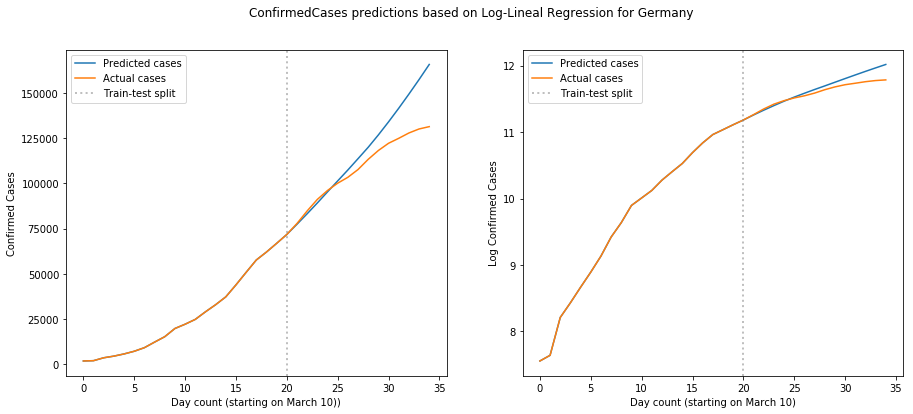

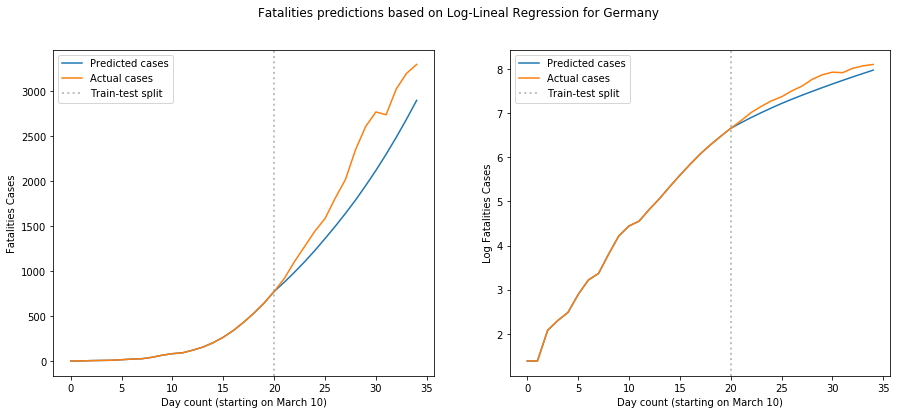

In [38]:
# Inputs
country_name = "Germany"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Albania**

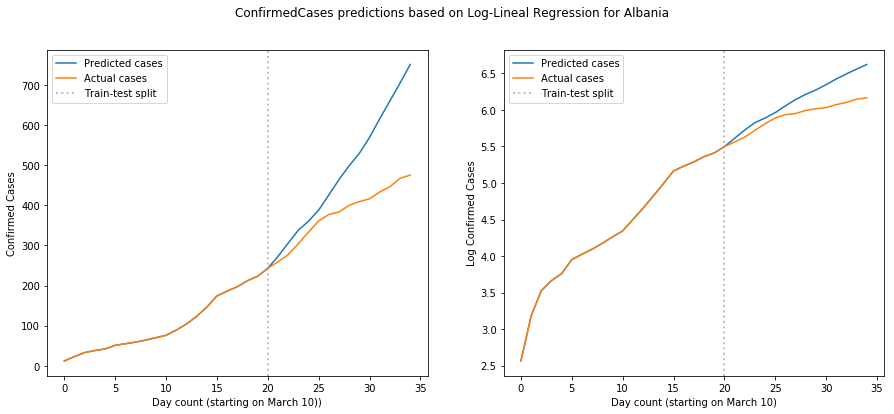

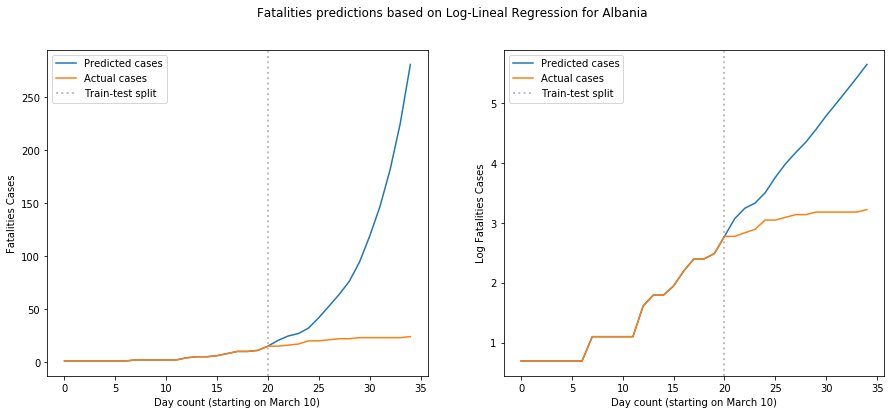

In [39]:
# Inputs
country_name = "Albania"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 7

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Andorra**

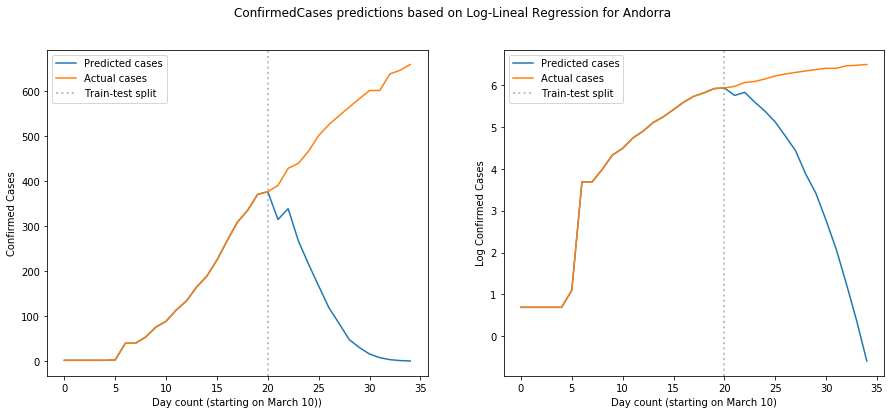

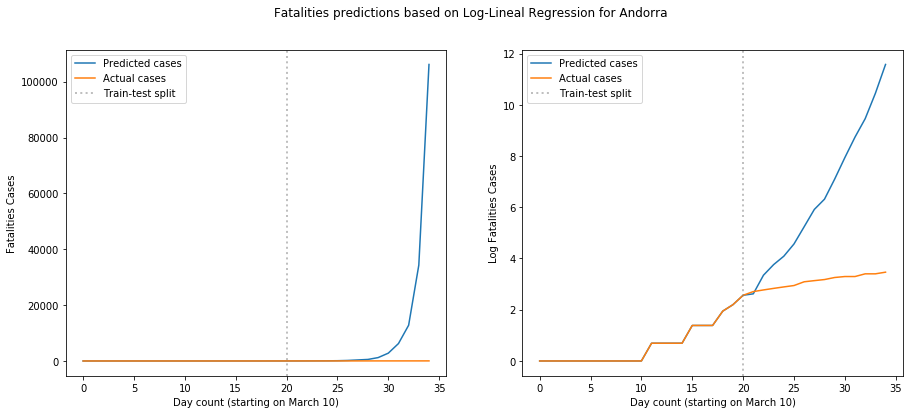

In [40]:
# Inputs
country_name = "Andorra"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 1

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)